# Introduction:
Our group project aims to determine which "kinds" of players are most likely to contribute a large amount of data by analyzing play time with personal history with Minecraft so that the research group can target those players in their recruiting efforts.


# The Data Sets:

 `players.csv` dataset contains 196 observations and 9 variables. <br><br>
         Variables: <br>
        <blockquote>`Experience`: What their previous experience with Minecraft is <br> 
        `Subscribe`: If they are subscribed to email updates or not <br>
        `HashedEmail`: encrypted format of their email <br>
        `Name`: Name on plaicraft.ai <br>
        `Gender`: recorded gender <br>
        `Age`: recorded age <br>
        `individualID`: individual id if available <br>
        `organizationName`: Name of associated organization if available <br>
        `played_hours`: total hours contributed on plaicraft.ai<br></blockquote>

    
`game_time.csv` has 1535 rows and 5 variables: <br><br>
    Variables: <br>
    <blockquote>`hashedEmail`: encrypted format of their email<br>
    `start_time`: start time of session<br>
    `end_time`:end time of session<br>
    `original_start_time`: start time of session in reference to POSIX<br>
    `original_end_time`: end time of session in reference to POSIX</blockquote>

In [12]:
#loading libraries
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(dplyr)
library(caret)
#set seed
set.seed(2024)

In [13]:
url1 <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
url2 <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
play_data <- read_csv(url1)
session_data <- read_csv(url2)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [14]:
play_data_select <- play_data|>
                     select(-individualId, -organizationName)

session_data_select <- session_data |>
                        mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
                        end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")) |>
                        select(-original_start_time, -original_end_time)

combined_data <- left_join(play_data_select, session_data_select, by = "hashedEmail")

In [15]:
play_data_mutate<-play_data_select|>
#mutating genders other than Male and Female into a catagory "Other"
mutate(gender = case_when(gender == "Agender" ~ "Other",
                          gender == "Non-binary" ~ "Other",
                          gender == "Other" ~ "Other",
                          gender == "Prefer not to say" ~ "Other",
                          gender == "Two Spirited" ~ "Other",
                          gender == "Male" ~ "Male",
                          gender == "Female" ~ "Female",))|>
#omitting NA responses
        na.omit()

In [16]:
#splitting the data set into training and testing
minecraft_split<-initial_split(play_data_mutate, prop=0.75, strata = played_hours)
minecraft_train<-training(minecraft_split)
minecraft_test<-testing(minecraft_split)
head(minecraft_train)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17
Veteran,TRUE,bbe2d83de678f519c4b3daa7265e683b4fe2d814077f9094afd11d8f217039ec,0.0,Nyla,Female,22


In [17]:
#dummifying the training variables

minecraft_train_select<-minecraft_train|>
select(experience,played_hours,gender)

dmy_train <- dummyVars("~ .", data = minecraft_train_select)
minecraft_dummy_train <- data.frame(predict(dmy_train, newdata = minecraft_train_select))
head(minecraft_dummy_train)
#dummifying the training variables
minecraft_test_select<-minecraft_test|>
select(experience,played_hours,gender)

dmy_test <- dummyVars("~ .", data = minecraft_test_select)
minecraft_dummy_test <- data.frame(predict(dmy_test, newdata = minecraft_test_select))
head(minecraft_dummy_test)

,experienceAmateur,experienceBeginner,experiencePro,experienceRegular,experienceVeteran,played_hours,genderFemale,genderMale,genderOther
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,1,0.0,0,1,0
2,1,0,0,0,0,0.0,1,0,0
3,0,0,0,1,0,0.0,1,0,0
4,1,0,0,0,0,0.0,0,1,0
5,1,0,0,0,0,0.1,0,1,0
6,0,0,0,0,1,0.0,1,0,0


,experienceAmateur,experienceBeginner,experiencePro,experienceRegular,experienceVeteran,played_hours,genderFemale,genderMale,genderOther
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,1,0,0.1,0,1,0
2,1,0,0,0,0,0.0,0,1,0
3,1,0,0,0,0,48.4,1,0,0
4,1,0,0,0,0,0.1,1,0,0
5,0,1,0,0,0,1.0,0,1,0
6,1,0,0,0,0,0.7,1,0,0


In [18]:
mean_play<- minecraft_train|>
group_by(experience)|>
    summarize(average_hours=mean(played_hours))
mean_play

experience,average_hours
<chr>,<dbl>
Amateur,3.8512195
Beginner,0.7208333
Pro,3.2363636
Regular,23.3107143
Veteran,0.7526316


In [ ]:
plot1 <- ggplot(minecraft_train, aes(x = experience, y = played_hours)) +
         geom_bar(stat = "identity") +
         labs(
              title = "Figure 1.1 Total Play Time contributed by Experience Level",
              x = "Experience Level",
              y = "Play Time (Hours)"
              )

plot2 <- ggplot(minecraft_train, aes(x = gender, y = played_hours)) +
         geom_bar(stat = "identity") +
         labs(
              title = "Figure 1.2 Total Play Time by Gender",
              x = "Gender",
              y = "Play Time (Hours)"
              )
plot3 <- ggplot(minecraft_train, aes(x = age, y = played_hours)) +
         geom_point(alpha = 0.5, color = "blue") +
         xlim(0,50)
         labs(
              title = "Figure 1.3 Relationship Between Age and Play Time",
              x = "Age",
              y = "Play Time (Hours)"
              ) 

plot4 <- ggplot(mean_play, aes(x = experience, y= average_hours)) +
         geom_bar(stat = "identity") +
         labs(
              title = "Figure 1.4 Average Play Time contributed by Experience Level",
              x = "Experience Level",
              y = "Play Time (Hours)"
              )
#limited y axis due to outliers so we can visualize better
plot5 <- ggplot(minecraft_train, aes(x = experience, y = played_hours)) +
         geom_boxplot(fill= "blue") +
         ylim(0,3)+
         labs(
              title = "Figure 1.5 Play Time contributed by Experience Level",
              x = "Experience Level",
              y = "Play Time (Hours)"
              )
plot6 <- ggplot(minecraft_train, aes(x = subscribe, y = played_hours)) +
         geom_boxplot(fill= "blue") +
         ylim(0,3)+
         labs(
              title = "Figure 1.6 Play Time contributed by subscription status",
              x = "Subscription status",
              y = "Play Time (Hours)"
              )

In [ ]:
plot1

In [ ]:
plot2

In [ ]:
plot3

In [ ]:
plot4

In [ ]:
plot5

In [ ]:
plot6

## Creating the model
Our group decided on k-nn regression.

In [8]:
#creating the model

#using cross-validation to choose K

#create recipe and scale
minecraft_recipe<-recipe(played_hours ~., minecraft_dummy_train)|>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())
#creating model specification
minecraft_spec<-nearest_neighbor(weight_func = "rectangular",
                                 neighbors=tune())|>
                set_engine("kknn")|>
                set_mode("regression")

#create a 5-fold cross-validation object
minecraft_vfold<-vfold_cv(minecraft_dummy_train, v = 5, strata = played_hours)

#creating a workflow
minecraft_workflow<-workflow()|>
                    add_recipe(minecraft_recipe)|>
                    add_model(minecraft_spec)

minecraft_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


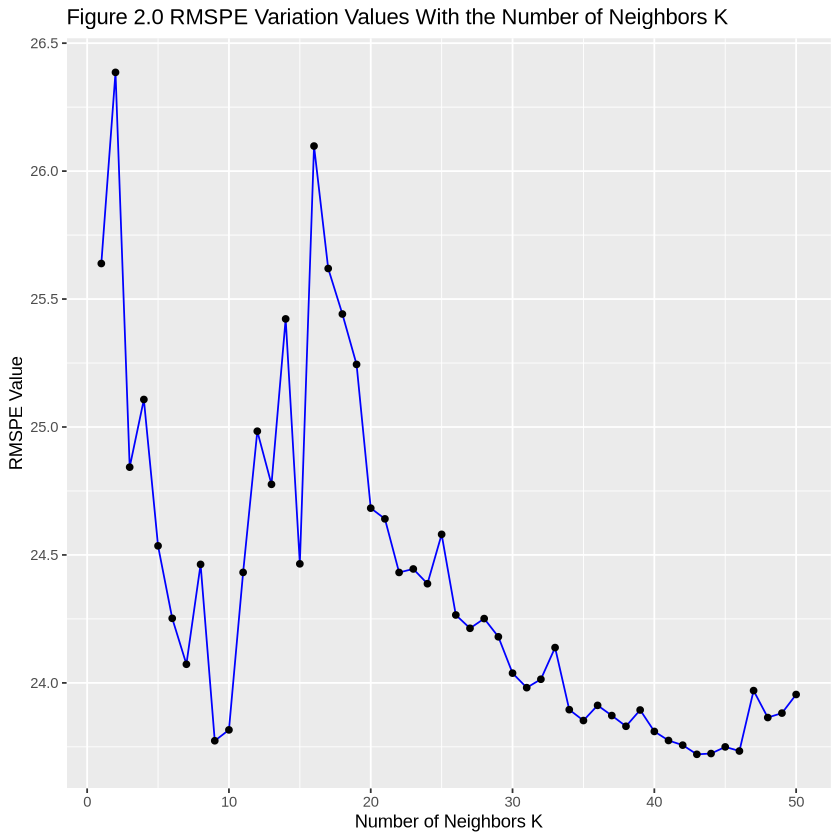

In [9]:
#run cross-validation for k between 1 and 50

gridvals<-tibble(neighbors=seq(from=1, to =50, by=1))
#results
minecraft_results<-minecraft_workflow|>
                   tune_grid(resamples = minecraft_vfold, grid = gridvals) |>
                   collect_metrics() |>
                   filter(.metric == "rmse")
#visualizing results
results_plot<-ggplot(minecraft_results, aes(x=neighbors, y=mean))+
                geom_line(color="blue")+
                geom_point()+
                labs(title="Figure 2.0 RMSPE Variation Values With the Number of Neighbors K",
                    x="Number of Neighbors K",
                     y="RMSPE Value")
results_plot

In [10]:
#find minimum RMSPE
minecraft_min <- minecraft_results |>
  filter(mean == min(mean))

minecraft_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
43,rmse,standard,23.72082,5,9.266231,Preprocessor1_Model43


#### From cross validation, we have determined that the best value of K is 43. It has an error of 23.72082 hours.

In [11]:
#creating model specification with k=42
kmin<-minecraft_min|>pull(neighbors)

minecraft_spec<-nearest_neighbor(weight_func = "rectangular",
                                 neighbors=kmin)|>
                set_engine("kknn")|>
                set_mode("regression")

#retrain our model on the training set
#creating a workflow
minecraft_fit<-workflow()|>
                    add_recipe(minecraft_recipe)|>
                    add_model(minecraft_spec)|>
                    fit(data = minecraft_dummy_train)
#predict on test
minecraft_summary<-minecraft_fit|>
    predict(minecraft_dummy_test)|>
    bind_cols(minecraft_dummy_test)
head(minecraft_summary)

minecraft_metrics<-minecraft_summary|>
    metrics(truth=played_hours, estimate = .pred)|>
    filter(.metric=="rmse")
minecraft_metrics

.pred,experienceAmateur,experienceBeginner,experiencePro,experienceRegular,experienceVeteran,played_hours,genderFemale,genderMale,genderOther
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.372093,0,0,0,1,0,0.1,0,1,0
3.658140,1,0,0,0,0,0.0,0,1,0
7.897674,1,0,0,0,0,48.4,1,0,0
7.897674,1,0,0,0,0,0.1,1,0,0
1.797674,0,1,0,0,0,1.0,0,1,0
7.897674,1,0,0,0,0,0.7,1,0,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.17043


### Final model's test error is around 22.17043 hours which is close to the RMSPE value of our tuned model (23.72082 hours). This means our model appears to work well on new data that it has never seen before.